In [105]:
#Imports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot

import loompy
from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment, Trinarizer
from cytograph.manifold import GraphSkeletonizer
from typing import *

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [138]:
class GA_Aggregator:
    def __init__(self, *, f: Union[float, List[float]] = 0.5) -> None:
        self.f = f
        self.config = load_config() # Generic config, just to get the paths

    def fit(self, ds: loompy.LoomConnection, *, out_file: str, agg_spec: Dict[str, str] = None) -> None:
        '''
        Aggregate the Gene-Accessibility signal, find markers and call the auto-annotater
        
        Args:
            ds
        '''
        if agg_spec is None:
            agg_spec = {
                "Age": "tally",
                "Clusters": "first",
                "Class": "mode",
                "Total": "mean",
                "Sex": "tally",
                "Tissue": "tally",
                "SampleID": "tally",
                "TissuePool": "first",
                "Outliers": "mean",
                "PCW": "mean"
            }
        cells = ds.col_attrs["Clusters"] >= 0
        labels = ds.col_attrs["Clusters"][cells]
        n_labels = len(set(labels))

        logging.info("Aggregating clusters")
        ds.aggregate(out_file, None, "Clusters", "mean", agg_spec)
        with loompy.connect(out_file) as dsout:

            if n_labels <= 1:
                return

            logging.info("Computing cluster gene enrichment scores")
            self.mask = Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt"))
            fe = FeatureSelectionByMultilevelEnrichment(mask=self.mask)
            markers = fe.fit(ds)
            dsout.layers["enrichment"] = fe.enrichment

            dsout.ca.NCells = np.bincount(labels, minlength=n_labels)

            # Renumber the clusters
            logging.info("Renumbering clusters by similarity, and permuting columns")

            data = np.log(dsout[:, :] + 1)[markers, :].T
            D = pdist(data, 'correlation')
            Z = hc.linkage(D, 'ward', optimal_ordering=True)
            ordering = hc.leaves_list(Z)

            # Permute the aggregated file, and renumber
            dsout.permute(ordering, axis=1)
            dsout.ca.Clusters = np.arange(n_labels)

            # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
            data = np.log(dsout[:, :] + 1)[markers, :].T
            D = pdist(data, 'correlation')
            dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

            # Renumber the original file, and permute
            d = dict(zip(ordering, np.arange(n_labels)))
            new_clusters = np.array([d[x] if x in d else -1 for x in ds.ca.Clusters])
            ds.ca.Clusters = new_clusters
            ds.permute(np.argsort(ds.col_attrs["Clusters"]), axis=1)

            # Reorder the genes, markers first, ordered by enrichment in clusters
            logging.info("Permuting rows")
            mask = np.zeros(ds.shape[0], dtype=bool)
            mask[markers] = True
            # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
            gene_order = np.zeros(ds.shape[0], dtype='int')
            gene_order[mask] = np.argmax(dsout.layer["enrichment"][mask, :], axis=1)
            gene_order[~mask] = np.argmax(dsout.layer["enrichment"][~mask, :], axis=1) + dsout.shape[1]
            gene_order = np.argsort(gene_order)
            ds.permute(gene_order, axis=0)
            dsout.permute(gene_order, axis=0)

            if n_labels > 300:
                dsout.ca.MarkerGenes = np.empty(n_labels, dtype='str')
                dsout.ca.AutoAnnotation = np.empty(n_labels, dtype='str')
                return

            logging.info("Trinarizing")
            if type(self.f) is list or type(self.f) is tuple:
                for ix, f in enumerate(self.f):  # type: ignore
                    trinaries = Trinarizer(f=f).fit(ds)
                    if ix == 0:
                        dsout.layers["trinaries"] = trinaries
                    else:
                        dsout.layers[f"trinaries_{f}"] = trinaries
            else:
                trinaries = Trinarizer(f=self.f).fit(ds)  # type:ignore
                dsout.layers["trinaries"] = trinaries

            logging.info("Computing auto-annotation")
            AutoAnnotator(root=config.paths.autoannotation, ds=dsout).annotate(dsout)

            logging.info("Computing auto-auto-annotation")
            AutoAutoAnnotator(n_genes=6).annotate(dsout)

            if "skeletonize" in config.steps:
                logging.info("Graph skeletonization")
                GraphSkeletonizer(min_pct=1).abstract(ds, dsout)

In [173]:
fdir = '/data/proj/scATAC/chromograph/build_20200426/Cerebellum'
GAfile = os.path.join(fdir, 'Cerebellum_GA.loom')
binfile = os.path.join(fdir, 'Cerebellum.loom')

with loompy.connect(GAfile, 'r') as ds:
    with loompy.connect(binfile, 'r') as ds2:
        match = {k:v for v, k in enumerate(ds.ca.CellID)}
        new_index = np.array([match[x] for x in ds2.ca.CellID]).argsort()


0
['10X250_2:GCTGAGCTCAGGCGCT-1' '10X250_2:AAATGCCCACCTGGTG-1'
 '10X250_1:ATGGATCCAAGTCTGT-1' '10X250_2:TACATGGCAGCCACGT-1'
 '10X250_1:TGTACAGCAAATTCCG-1']
['10X250_2:GCTGAGCTCAGGCGCT-1' '10X250_2:AAATGCCCACCTGGTG-1'
 '10X250_1:ATGGATCCAAGTCTGT-1' '10X250_2:TACATGGCAGCCACGT-1'
 '10X250_1:TGTACAGCAAATTCCG-1']


In [225]:
fdir = '/data/proj/scATAC/chromograph/build_20200510/All'
file = os.path.join(fdir, 'All.loom')
out_file = os.path.join(fdir, 'All_GA.agg.loom')

agg_spec = {
    "Age": "tally",
    "Clusters": "first",
    "Class": "mode",
    "Total": "mean",
    "Sex": "tally",
    "Tissue": "tally",
    "SampleID": "tally",
    "TissuePool": "first",
    "Outliers": "mean",
    "PCW": "mean"
}

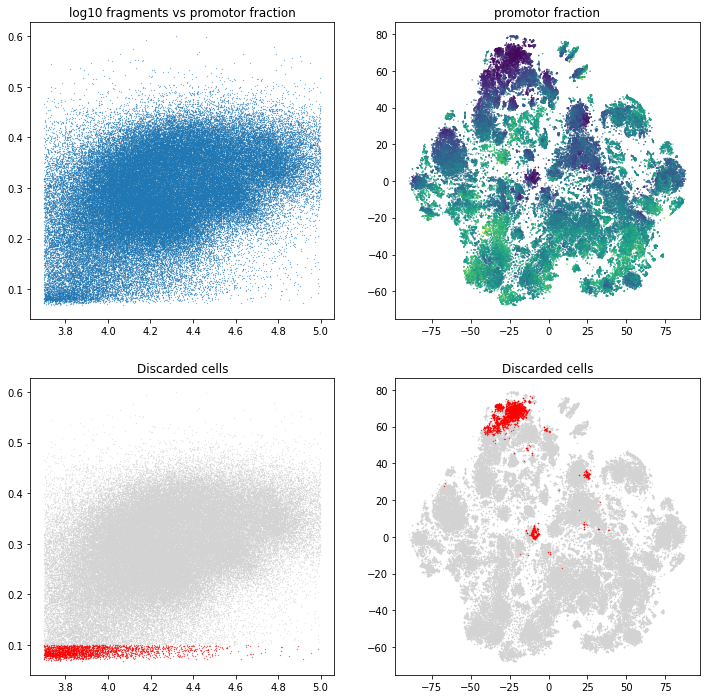

In [226]:
with loompy.connect(file, 'r') as ds:
    
    fig, ax = plt.subplots(2,2,figsize=(12,12))
    ax = ax.flatten()
    
    prom_score = ds.ca.promoter_region_fragments/ds.ca.passed_filters
    ax[0].scatter(np.log10(ds.ca.passed_filters), prom_score, s=0.05)
    ax[0].set_title('log10 fragments vs promotor fraction')

    ax[1].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c= prom_score, s = 0.1)
    ax[1].set_title('promotor fraction')

    
    disc = prom_score < 0.1
    ax[2].scatter(np.log10(ds.ca.passed_filters), prom_score, s=0.05, c='lightgrey')
    ax[2].scatter(np.log10(ds.ca.passed_filters)[disc], prom_score[disc], s=0.05, c='red')
    ax[2].set_title('Discarded cells')
    
    ax[3].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c = 'lightgrey', s= 0.1)
    ax[3].scatter(ds.ca.TSNE[disc,0], ds.ca.TSNE[disc,1], c = 'red', s= 0.1)
    ax[3].set_title('Discarded cells')


In [189]:
with loompy.connect(file, 'r') as ds:
    print(np.min(ds.ca.passed_filters))

5001
3.6989700043360187


In [227]:
out_file.split('/')[-1].split('_')[0]

'All'

In [139]:
with loompy.connect(file) as ds:
    cells = ds.col_attrs["Clusters"] >= 0
    labels = ds.col_attrs["Clusters"][cells]
    n_labels = len(set(labels))

    logging.info("Aggregating clusters")
    logging.info(f'No NaN or INF: {np.isfinite(ds[""][:,:]).all()}')
    ds.aggregate(out_file, None, "Clusters", "mean", agg_spec)
    
    with loompy.connect(out_file) as dsout:
#          if n_labels <= 1:
#             return
        logging.info("Computing cluster gene enrichment scores")
        
        mask = Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt"))
        fe = FeatureSelectionByMultilevelEnrichment(mask=mask)
        markers = fe.fit(ds)
        dsout.layers["enrichment"] = fe.enrichment
        dsout.ca.NCells = np.bincount(labels, minlength=n_labels)

        # Renumber the clusters
        logging.info("Renumbering clusters by similarity, and permuting columns")

        data = np.log(dsout[:, :] + 1)[markers, :].T
        D = pdist(data, 'correlation')
        Z = hc.linkage(D, 'ward', optimal_ordering=True)
        ordering = hc.leaves_list(Z)

        # Permute the aggregated file, and renumber
        dsout.permute(ordering, axis=1)
        dsout.ca.Clusters = np.arange(n_labels)

        # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
        data = np.log(dsout[:, :] + 1)[markers, :].T
        D = pdist(data, 'correlation')
        dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

        # Renumber the original file, and permute
        d = dict(zip(ordering, np.arange(n_labels)))
        new_clusters = np.array([d[x] if x in d else -1 for x in ds.ca.Clusters])
        ds.ca.Clusters = new_clusters
        ds.permute(np.argsort(ds.col_attrs["Clusters"]), axis=1)

        # Reorder the genes, markers first, ordered by enrichment in clusters
        logging.info("Permuting rows")
        mask = np.zeros(ds.shape[0], dtype=bool)
        mask[markers] = True
        # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
        gene_order = np.zeros(ds.shape[0], dtype='int')
        gene_order[mask] = np.argmax(dsout.layer["enrichment"][mask, :], axis=1)
        gene_order[~mask] = np.argmax(dsout.layer["enrichment"][~mask, :], axis=1) + dsout.shape[1]
        gene_order = np.argsort(gene_order)
        ds.permute(gene_order, axis=0)
        dsout.permute(gene_order, axis=0)

        if n_labels > 300:
            dsout.ca.MarkerGenes = np.empty(n_labels, dtype='str')
            dsout.ca.AutoAnnotation = np.empty(n_labels, dtype='str')

13:00:14 INFO     Aggregating clusters
13:01:06 INFO     No NaN or INF: True
13:04:57 INFO     Computing cluster gene enrichment scores
13:04:58 INFO     Multilevel marker selection with 97 clusters at the leaf level
13:04:58 INFO     Analyzing 4 higher levels with [25, 10, 5, 2] clusters
13:04:58 INFO     Computing enrichment statistic
13:14:51 INFO     Identifying valid genes
13:15:48 INFO     Found 970 marker genes at level 0 (leaves)
13:15:48 INFO     Computing enrichment statistic
13:25:26 INFO     Found 250 marker genes at level 1
13:25:26 INFO     Computing enrichment statistic
13:35:04 INFO     Found 100 marker genes at level 2
13:35:04 INFO     Computing enrichment statistic
13:44:32 INFO     Found 50 marker genes at level 3
13:44:32 INFO     Computing enrichment statistic
13:53:44 INFO     Found 20 marker genes at level 4
13:53:44 INFO     Renumbering clusters by similarity, and permuting columns
14:13:01 INFO     Permuting rows


In [ ]:
temp_f = [0.65]

with loompy.connect(file) as ds:
    cells = ds.col_attrs["Clusters"] >= 0
    labels = ds.col_attrs["Clusters"][cells]
    n_labels = len(set(labels))

    with loompy.connect(out_file) as dsout:
        
        logging.info("Trinarizing")
        if type(temp_f) is list or type(temp_f) is tuple:
            for ix, f in enumerate(temp_f):  # type: ignore
                logging.info(f'Using f {f}')
                trinaries = Trinarizer(f=f).fit(ds)
                if ix == 0:
                    dsout.layers["trinaries"] = trinaries
                else:
                    dsout.layers[f"trinaries_{f}"] = trinaries
        else:
            trinaries = Trinarizer(f=self.f).fit(ds)  # type:ignore
            dsout.layers["trinaries"] = trinaries

        logging.info("Computing auto-annotation")
        AutoAnnotator(root="/home/camiel/auto-annotation/Human", ds=dsout).annotate(dsout)

        logging.info("Computing auto-auto-annotation")
        AutoAutoAnnotator(n_genes=6).annotate(dsout)

        print(dsout.ca.AutoAnnotation)
#         if "skeletonize" in config.steps:
#             logging.info("Graph skeletonization")
#             GraphSkeletonizer(min_pct=1).abstract(ds, dsout)

#         logging.info("Graph skeletonization")
#         GraphSkeletonizer(min_pct=1).abstract(ds, dsout)

In [270]:
temp_file = '/data/proj/scATAC/chromograph/build_20200510/All/All_GA.agg.loom'
with loompy.connect(temp_file, 'r') as dsout:
    print(dsout['enrichment'][:,0].shape)
    print(dsout.ra.Gene[np.sum(dsout.ra.MultilevelMarkers, axis=1)>0])
    print(dsout.ca.MarkerGenes)

(19901,)
['RP11-812E19.9' 'SPDYE6' 'NKX2-5' 'C1orf233' 'UBL4B' 'NKX1-1' 'POU4F3'
 'C1QL2' 'SCGB3A2' 'PFN3' 'VGF' 'TCHH' 'RP11-1263C18.3' 'UNCX' 'SPZ1'
 'NHLH1' 'PRDM13' 'POU4F2' 'OLIG3' 'FOXD4L3' 'GPR52' 'C6orf15' 'DEFB107A'
 'DEFB105B' 'RP11-437G21.2' 'F8A3' 'USP17L19' 'SAPCD1' 'GPBAR1' 'NEUROD1'
 'GUCA2A' 'GCG' 'CELA2B' 'CELA2A' 'CCR2' 'MUSTN1' 'FABP7' 'CD1E' 'FAM25C'
 'CH17-385C13.3' 'UPK3BL' 'PPIAL4G' 'USP17L4' 'OR5F1' 'TP53TG3D' 'CT47B1'
 'ANP32D' 'USP17L1' 'OR4S2' 'CCL16' 'MTRNR2L11' 'RP11-294C11.1'
 'RP11-69A21.2' 'TNP1' 'CTAGE8' 'C1QTNF3' 'CXorf67' 'MYMX' 'RNF186'
 'KRTAP16-1' 'MBD3L5' 'PRAMEF13' 'RP11-294C11.3' 'TSPY2' 'RP11-85L21.3'
 'TSPY4' 'CRYAA' 'PRAMEF7' 'MBD3L2' 'UBTFL1' 'ZNF645' 'CD180' 'KRTAP29-1'
 'PRR20B' 'OR4C15' 'OR5J2' 'LYL1' 'CCL4L2' 'TYROBP' 'CCL3L3' 'CCL3' 'IL1B'
 'TREM2' 'CCL4' 'TAGAP' 'CD248' 'PPIAL4C' 'CD93' 'CCRL2' 'SDPR' 'RXFP4'
 'LRRC70' 'CXCL8' 'SPANXA2' 'RHOXF2B' 'CTB-25J19.1' 'DEFB106B' 'OR2T5'
 'RP11-219C24.6' 'BIRC8' 'SPANXC' 'ELOA3B' 'RHOXF2' 'OR4C

In [304]:
temp_file = '/data/proj/scATAC/chromograph/build_20200510/All/All_GA.agg.loom'
with loompy.connect(temp_file, 'r+') as dsout:
    k = 10
#     for i in range(dsout.shape[1]):
#         Most_enriched.append(dsout.ra.Gene[dsout['enrichment'][:,i].argsort()[::-1][:k]])
#     Most_enriched = [dsout.ra.Gene[dsout['enrichment'][:,i].argsort()[::-1][:k]].tolist() for i in range(dsout.shape[1])]
#     dsout.ca.Most_enriched = [" ".join(enr) for enr in Most_enriched]

In [319]:
import chromograph
from chromograph.pipeline import config
from chromograph.pipeline.utils import div0
import cytograph as cg
from cytograph.manifold import BalancedKNN

import sklearn.metrics
from scipy.spatial import distance
import networkx as nx
from scipy import sparse
from typing import *
import pickle
from tqdm import tqdm

import logging
f = '/data/proj/scATAC/chromograph/build_20200510/All/All_GA.loom'
with loompy.connect(f) as ds:
    ## Loading the network
    bnn = BalancedKNN(k=25, metric='euclidean', maxl=2 * 25, sight_k=2 * 25, n_jobs=-1)
    bnn.bknn = ds.col_graphs.KNN

    logging.info('Smoothing over the graph')
    ds['smooth'] = 'float32'
    progress = tqdm(total = ds.shape[0])
    for (ix, selection, view) in ds.scan(axis=0, batch_size=512):
        ds['smooth'][selection,:] = bnn.smooth_data(view['FPKM'][:,:], only_increase=True)
        progress.update(512)
    progress.close()

14:49:22 INFO     Smoothing over the graph

 98%|█████████▊| 19456/19901 [33:39<00:19, 23.16it/s]
19968it [33:51,  9.83it/s]                           


In [320]:
import cytograph.plotting as cgplot
temp_file = '/data/proj/scATAC/chromograph/build_20200511/All/All_GA.loom'
temp_agg = '/data/proj/scATAC/chromograph/build_20200511/All/All_GA.agg.loom'
with loompy.connect(temp_file, 'r') as ds:
    with loompy.connect(temp_agg, 'r') as dsagg:
        cgplot.radius_characteristics(ds, out_file= "/home/camiel/misc/All_neighborhoods.png")
        cgplot.TF_heatmap(ds, dsagg, out_file="/home/camiel/misc/All_TFs_heatmap.pdf", layer="")
        cgplot.TF_heatmap(ds, dsagg, out_file="/home/camiel/misc/All_TFs_heatmap_smoothed.pdf", layer="smooth")
        cgplot.markerheatmap(ds, dsagg, out_file="/home/camiel/misc/All_markers_heatmap.pdf", layer="")
        cgplot.markerheatmap(ds, dsagg, out_file="/home/camiel/misc/All_markers_heatmap_smoothed.pdf", layer="smooth")
        cgplot.metromap(ds, dsagg, out_file="/home/camiel/misc/All_metromap.png", embedding = 'UMAP')

['', 'enrichment', 'trinaries', 'trinaries_0.2', 'trinaries_0.35', 'trinaries_0.5', 'trinaries_0.65', 'trinaries_0.8']
['P-PALL P-PALL-M' 'NBL P-PALL P-PALL-M P-VLGE'
 'P-FP1 P-PALL P-PALL-M P-VLGE' 'P-FP1 P-PALL P-PALL-M P-VLGE' 'P-FP1'
 'P-FP1' 'P-FP1' 'P-FP1' 'NBL P-FP1 P-PALL P-PALL-M P-VLGE'
 'E-SCHWL M-PER NP-TRH P-FP1 P-PALL P-PALL-M' 'P-FP1 P-PALL P-PALL-M' ''
 'M-PER P-FP1' 'P-FP1' '' '' 'P-FP1' '' 'P-FP1' '' '' '' '' '' 'P-FP1' ''
 '' '' 'NBL P-PALL P-PALL-M' 'NBL P-PALL P-PALL-M'
 'NBL NP-TRH P-PALL P-PALL-M P-VLGE'
 'E-SCHWL NBL NP-POMC NP-TRH P-FPL P-PALL P-PALL-M P-VLGE'
 'P-FP1 P-PALL P-PALL-M' 'P-FP1' '' 'P-PALL' '' 'NT-GABA P-PALL P-PALL-M'
 'NT-GLY NT-VGLUT1 P-PALL P-PALL-M' ''
 'NEUR NT-GLY NT-VGLUT1 P-PALL P-PALL-M' 'NEUR NT-GABA' ''
 'P-PALL P-PALL-M' 'NBL NT-GLY NT-VGLUT1 NT-VGLUT2 P-PALL P-PALL-M S-CC'
 'NBL NT-GLY NT-VGLUT1 NT-VGLUT2 P-DLGE P-PALL P-PALL-M S-CC' 'NT-VGLUT2'
 '' '' 'NT-VGLUT1 NT-VGLUT2 NT-VGLUT3'
 'E-SCHWL NBL NP-TRH NT-GLY NT-NOR NT-VGLUT1 NT-VG

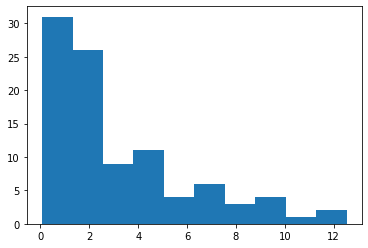

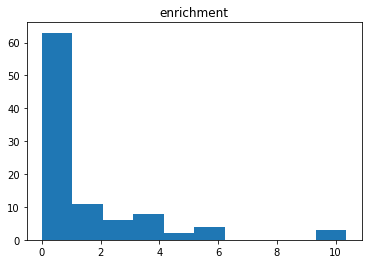

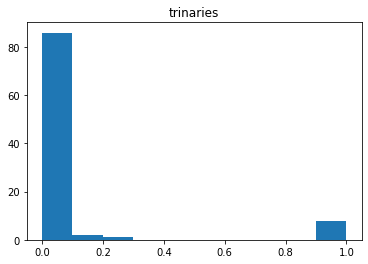

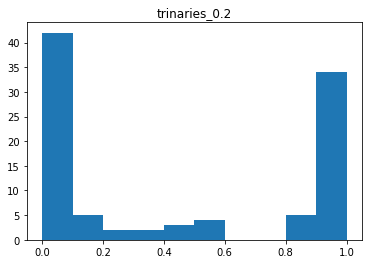

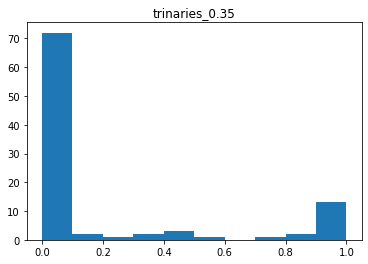

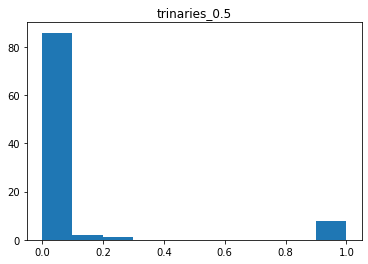

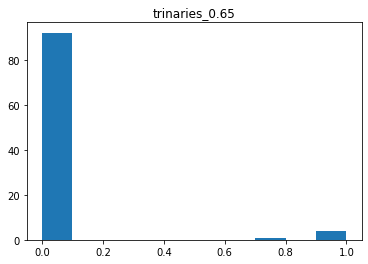

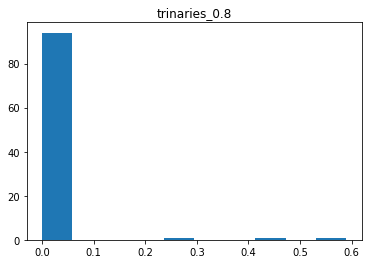

In [183]:
with loompy.connect(out_file) as dsout:
    print(dsout.layers.keys())
    print(dsout.ca.AutoAnnotation)
    for layer in dsout.layers:
        plt.figure()
        plt.hist(dsout[layer][dsout.ra.Gene=='FABP7',:][0])
        plt.title(layer)